In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import regularizers
from joblib import dump, load

from tensorflow.keras.datasets import mnist


In [3]:
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask].reset_index()
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df


In [4]:
# clear_df = pd.read_pickle("clear_functional.pkl")
clear_df = pd.read_pickle("clear_functional_emovo.pkl")

# clear_df = pd.read_pickle("pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("pitch_functional_emovo.pkl")

labels = clear_df["label"].unique()
# labels = ['disgust', 'joy', 'fear', 'anger', 'surprise', 'sadness']
labels 

array(['disgust', 'joy', 'neutrality', 'fear', 'anger', 'surprise',
       'sadness'], dtype=object)

In [5]:
df = []

for i,emotion in enumerate(labels):
    df.append(get_emo_df(emotion,clear_df))

Processing disgust ...
Processed 84 file for disgust
Processing joy ...
Processed 84 file for joy
Processing neutrality ...
Processed 84 file for neutrality
Processing fear ...
Processed 84 file for fear
Processing anger ...
Processed 84 file for anger
Processing surprise ...
Processed 84 file for surprise
Processing sadness ...
Processed 83 file for sadness


In [6]:
def get_data(df):
    data_classes = (list((df["label"].unique())))
    Y = keras.utils.to_categorical(list((df["label"].apply(data_classes.index))))
    X = pd.concat(df["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())


    X_train, X_test, y_train, y_test= train_test_split(_X, Y, test_size=.2, random_state=24)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=24)
    # print(len(X_train), len(X_val), len(X_test))

    # X_train.to_numpy()
    return X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy(), y_train, y_val, y_test

In [7]:
def get_rec_error(ae):
    errors = {}
    for i in labels:
        errors[i] = None
    for i in range(len(labels)):
        data = df[i]
        _X_train, _X_val, _X_test = get_data(data)
        reconstructed_X = ae.predict(_X_test)
        mse_per_feature = ((_X_test - reconstructed_X)**2).mean(axis=0)
        errors[labels[i]] = np.mean(mse_per_feature)
    return errors
        

In [8]:
def build_autoencoder(input_dim, neurons_in=16, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    model = keras.Sequential()
    model.add(Input(shape= (input_dim,)))


    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    

    # encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    # encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(input_l)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    model.add(Dense(neurons_in, activation='relu', name='bottleneck'))

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    # decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    # decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    # Dense(89, activation=act_function, name='output_l')(decoded_l3)
    model.add(Dense(input_dim, activation=act_function, name='output_l'))
    # ac = Model(input_l,output_l)
    
    # model.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return model

In [ ]:
# def build_autoencoder(input_dim):
    
#     input_l = Input(shape=(input_dim,),name='input_l')

#     encoded_l1 = Dense(64, activation='relu', name='encoded_1')(input_l) 
#     encoded_l2 = Dense(32, activation='relu', name='encoded_2')(encoded_l1)
#     # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

#     bottleneck = Dense(16, activation='relu', name='bottleneck')(encoded_l2)

#     # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
#     decoded_l2 = Dense(32, activation='relu', name='decoded_4')(bottleneck)
#     decoded_l3 = Dense(64, activation='relu', name='decoded_5')(decoded_l2)

#     output_l = Dense(input_dim, activation='relu', name='output_l')(decoded_l3)

#     ac = Model(input_l,output_l)
    
#     # ac.compile(loss='binary_crossentropy', optimizer='adam')
    
#     return ac

In [9]:
def old_contrastive_loss(y_pred, y_true):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.dtypes.cast(y_true, y_pred.dtype)
    return y_true * tf.math.square(y_pred) + (1.0 - y_true) * tf.math.square(tf.math.maximum(1.0 - y_pred, 0.0))

In [72]:
import tensorflow as tf

# Loss personalizzata
def custom_loss(y_true, y_pred):
    
    class_labels = y_true[:, -1]        # Ultima colonna come etichetta di classe
    original_data = y_true[:, :-1]      # Restante parte come dati originali
    # tf.print((original_data))
    return contrastive_loss(original_data, y_pred, class_labels, alpha=1)
def contrastive_loss(y_true, y_pred, class_labels, alpha):
    """
    Funzione di loss contrastiva che:
    - Minimizza l'errore di ricostruzione per la classe target (class_labels = 1).
    - Massimizza l'errore di ricostruzione per le altre classi (class_labels = 0).
    """
    # Calcolo dell'errore di ricostruzione
    # print(y_true)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    classes = tf.math.bincount(class_labels)
    target = classes[0]
    non_target = classes[1]
    total = tf.add(target, non_target)
    target_div = 1 - tf.divide(target, total)
    non_target_div = 1 - tf.divide(non_target, total)
    # tf.print(non_target_div, target_div)

    reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True) 

    target_loss = class_labels * (reconstruction_loss) 
    target_div = tf.cast(target_div, target_loss.dtype)
    
    target_loss = tf.math.multiply(target_loss,target_div)
    # Penalità per le classi non target (class_labels = 0): amplificata con il parametro alpha
    non_target_loss = (1.0 - class_labels) * tf.square(tf.maximum(alpha - reconstruction_loss, 0.0)) 

    non_target_div = tf.cast(target_div, non_target_loss.dtype)
    non_target_loss = tf.math.multiply(non_target_loss, non_target_div)
    loss_tot = target_loss + non_target_loss
    return tf.reduce_mean(loss_tot)


In [58]:
from datetime import datetime  
def train_autoencoder(emotion,data, index):

    X_train, X_val, X_test, y_train, y_val, y_test = get_data(data)
    y_train = np.argmax(y_train, axis=-1)
    _y_train = np.array([1 if x == index else 0 for x in y_train]).reshape(-1,1)
    y_val = np.argmax(y_val, axis=-1)
    _y_val = np.array([1 if x == index else 0 for x in y_val]).reshape(-1,1)
    y_true = np.hstack([X_train, _y_train])
    _y_val = np.hstack([X_val, _y_val])
    y_test = np.argmax(y_test, axis=-1)
    _y_test = np.array([1 if x == index else 0 for x in y_test]).reshape(-1,1)


    ones = np.sum(_y_train)
    zeros = len(_y_train) - np.sum(_y_train) 
    total = len(_y_train)
    # print(total, ones, zeros)
    target_div = 1- (ones / total)
    non_target_div = 1- (zeros / total)
    print(f"non target: {non_target_div}, Target: {target_div}")
    class_weight = {0: 1-non_target_div,
                1: target_div}
    print(f"{np.count_nonzero(_y_train == 1)} examples for {emotion}")
    input_dim = X_train.shape[-1]   
    # print(input_dim)   
    # print(_y_train[:10])
    ae = build_autoencoder(input_dim, act_function="relu")

    name = datetime.now().strftime(f"model/autoencoders/contrastive/ae_{emotion}_%d_%m_%Y_%H_%M_%S.keras")
    print(f"training on {emotion}")
    print(f"Model name : {name}")
    ae.compile(optimizer='adam', loss=custom_loss)

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=0,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
    )
    ]
    # y_train = np.hstack([_X_train,np.ones((_X_train.shape[0],1))])
    # y_val = np.hstack([_X_val,np.ones((_X_val.shape[0],1))])

    history = ae.fit(X_train, y_true,
                validation_data = (X_val, _y_val),
                epochs=5000,
                batch_size=128,
                verbose=0,
                # class_weight = class_weight,
                callbacks = callbacks)
    print(history.history['val_loss'][-1])
    return ae

In [12]:
data_df = pd.concat([df[1],df[2], df[3], df[4], df[5], df[6]],ignore_index=True)

In [20]:
data_df = pd.concat([df[1],df[2], df[3]],ignore_index=True)

In [73]:
autoencoders = []
for i,emotion in enumerate(labels):
    autoencoders.append(train_autoencoder(emotion, clear_df, i))

non target: 0.1413333333333333, Target: 0.8586666666666667
53 examples for disgust
training on disgust
Model name : model/autoencoders/contrastive/ae_disgust_19_11_2024_13_07_58.keras
0.007020221091806889
non target: 0.128, Target: 0.872
48 examples for joy
training on joy
Model name : model/autoencoders/contrastive/ae_joy_19_11_2024_13_08_01.keras
0.030165959149599075
non target: 0.1466666666666666, Target: 0.8533333333333333
55 examples for neutrality
training on neutrality
Model name : model/autoencoders/contrastive/ae_neutrality_19_11_2024_13_08_04.keras
0.012844027020037174
non target: 0.15733333333333333, Target: 0.8426666666666667
59 examples for fear
training on fear
Model name : model/autoencoders/contrastive/ae_fear_19_11_2024_13_08_07.keras
0.015699634328484535
non target: 0.14400000000000002, Target: 0.856
54 examples for anger
training on anger
Model name : model/autoencoders/contrastive/ae_anger_19_11_2024_13_08_10.keras
0.021090958267450333
non target: 0.1413333333333333

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = []

y_pred = []
errors = []
_test = []
_er = []
tot_errors = []
for n in range(len(clear_df)):
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(clear_df)
    y_test = np.argmax(y_train, axis=-1)
    _y_test = np.array([1 if x == n else 0 for x in y_test]).reshape(-1,1)
    _test.append(_y_test)
# _test.append(_y_test)

for sample in X_train:
    _er = []
    for encoder in autoencoders:
        _er.append(mean_squared_error(sample,encoder.predict(sample.reshape(-1,88), verbose=0).reshape(88,)))
    errors.append(_er)
    y_pred.append(np.argmin(_er))
tot_errors.append(errors)
    


In [23]:
train_errors = errors
data_train = np.array(train_errors)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = []

y_pred = []
errors = []
_test = []
_er = []
tot_errors = []
for n in range(len(clear_df)):
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(clear_df)
    y_test = np.argmax(y_test, axis=-1)
    _y_test = np.array([1 if x == n else 0 for x in y_test]).reshape(-1,1)
    _test.append(_y_test)
# _test.append(_y_test)

for sample in X_test:
    _er = []
    for encoder in autoencoders:
        _er.append(mean_squared_error(sample,encoder.predict(sample.reshape(-1,88), verbose=0).reshape(88,)))
    errors.append(_er)
    y_pred.append(np.argmin(_er))
tot_errors.append(errors)
    


In [76]:
test_errors = errors
data_test = np.array(test_errors)

In [24]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data(clear_df)
y_test = np.argmax(y_train, axis=-1)
# y_test

In [25]:
emo = []

array_dati = data_train
array_indici = y_test


# Iteriamo sugli indici unici in array_indici
for indice_unico in np.unique(array_indici):
    # Troviamo le posizioni degli indici uguali all'indice unico
    posizioni = np.where(array_indici == indice_unico)[0]
    
    # Selezioniamo le righe corrispondenti da array_dati
    righe_selezionate = array_dati[posizioni]
    # print(righe_selezionate)
    # Aggiungiamo le righe selezionate alla lista principale
    emo.append(np.array(righe_selezionate.tolist()))

In [18]:
emo = []

array_dati = data_train
array_indici = y_train


# Iteriamo sugli indici unici in array_indici
for indice_unico in np.unique(array_indici):
    # Troviamo le posizioni degli indici uguali all'indice unico
    posizioni = np.where(array_indici == indice_unico)[0]
    
    # Selezioniamo le righe corrispondenti da array_dati
    righe_selezionate = array_dati[posizioni]
    
    # Aggiungiamo le righe selezionate alla lista principale
    emo.append(np.array(righe_selezionate.tolist()))

In [145]:
data_train[1]

array([0.3826331 , 0.31582162, 0.36499622, 0.35026145, 0.16637154,
       0.3429766 , 0.44608784], dtype=float32)

In [169]:
for i in range((emo[0].shape[-1])):
    print(np.mean(emo[0][:,i]))

10.480582813047013
10.155960694798884
9.52864976199168
9.224928864892924
16.26405556696766
8.854302685215789
17.78310262032275


In [140]:
np.mean(emo[0][:,0])

0.4185755555244053

In [43]:
emo_test_1 = []
emo_test_0 = []
emo_test = []
for i in range(len(data_test)):
    if _test[0][i] == 1:
        emo_test_0.append(list(data_test[i]))
    elif _test[1][i] == 1:
       emo_test_1.append(list(data_test[i]))
emo_test.append(np.array(emo_test_0))
emo_test.append(np.array(emo_test_1))

In [26]:
emo_1 = []
emo_0 = []
emo = []
for i in range(len(data_train)):
    if _test[0][i] == 1:
        emo_0.append(list(data_train[i]))
    elif _test[1][i] == 1:
        emo_1.append(list(data_train[i]))
emo.append(np.array(emo_0))
emo.append(np.array(emo_1))

In [21]:
len(emo)

2

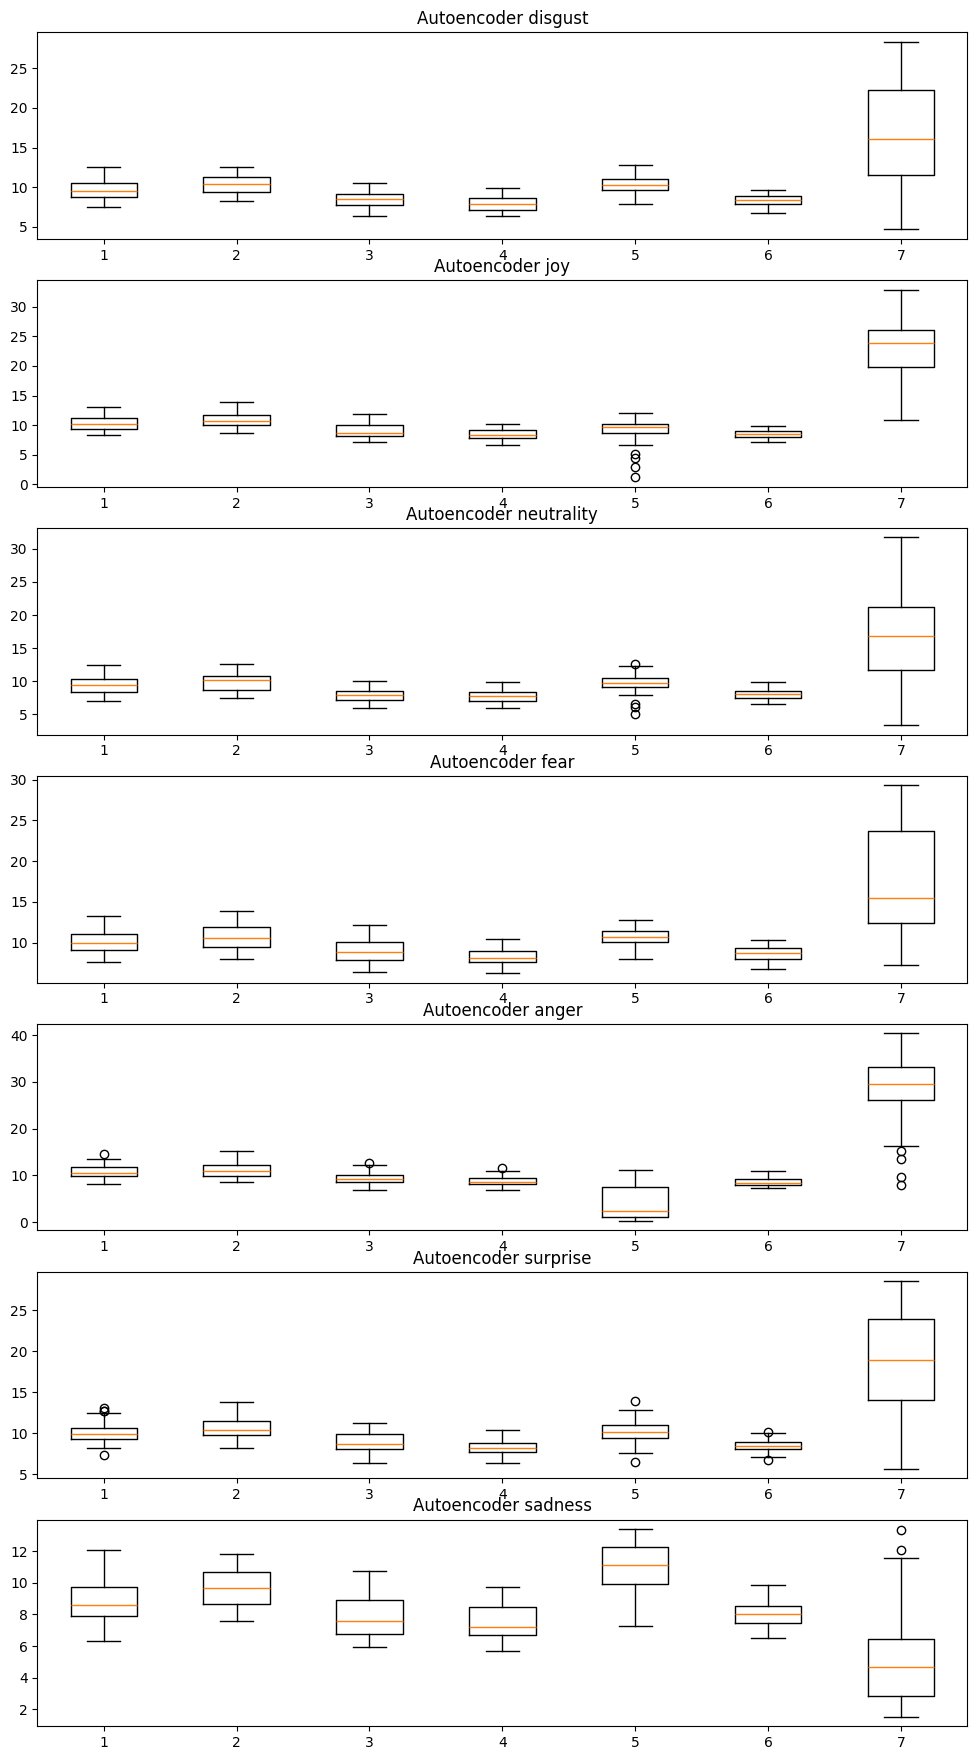

In [28]:
n_rows = 7
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(12,22))
# for x in range(n_rows):
for i in range(len(labels)):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)
        axes[i].boxplot([emo[i][:,0], emo[i][:,1],emo[i][:,2],emo[i][:,3],emo[i][:,4],emo[i][:,5],emo[i][:,6]])
        axes[i].set_title(f"Autoencoder {labels[i]}")
        # axes[i].set_ylim((0,5))
        # axes[x,i].set_title(f"{labels[i]}")
# fig.suptitle("Train")
# fig.savefig("Boxplot_Contrastive_Total_no_Neutrality")

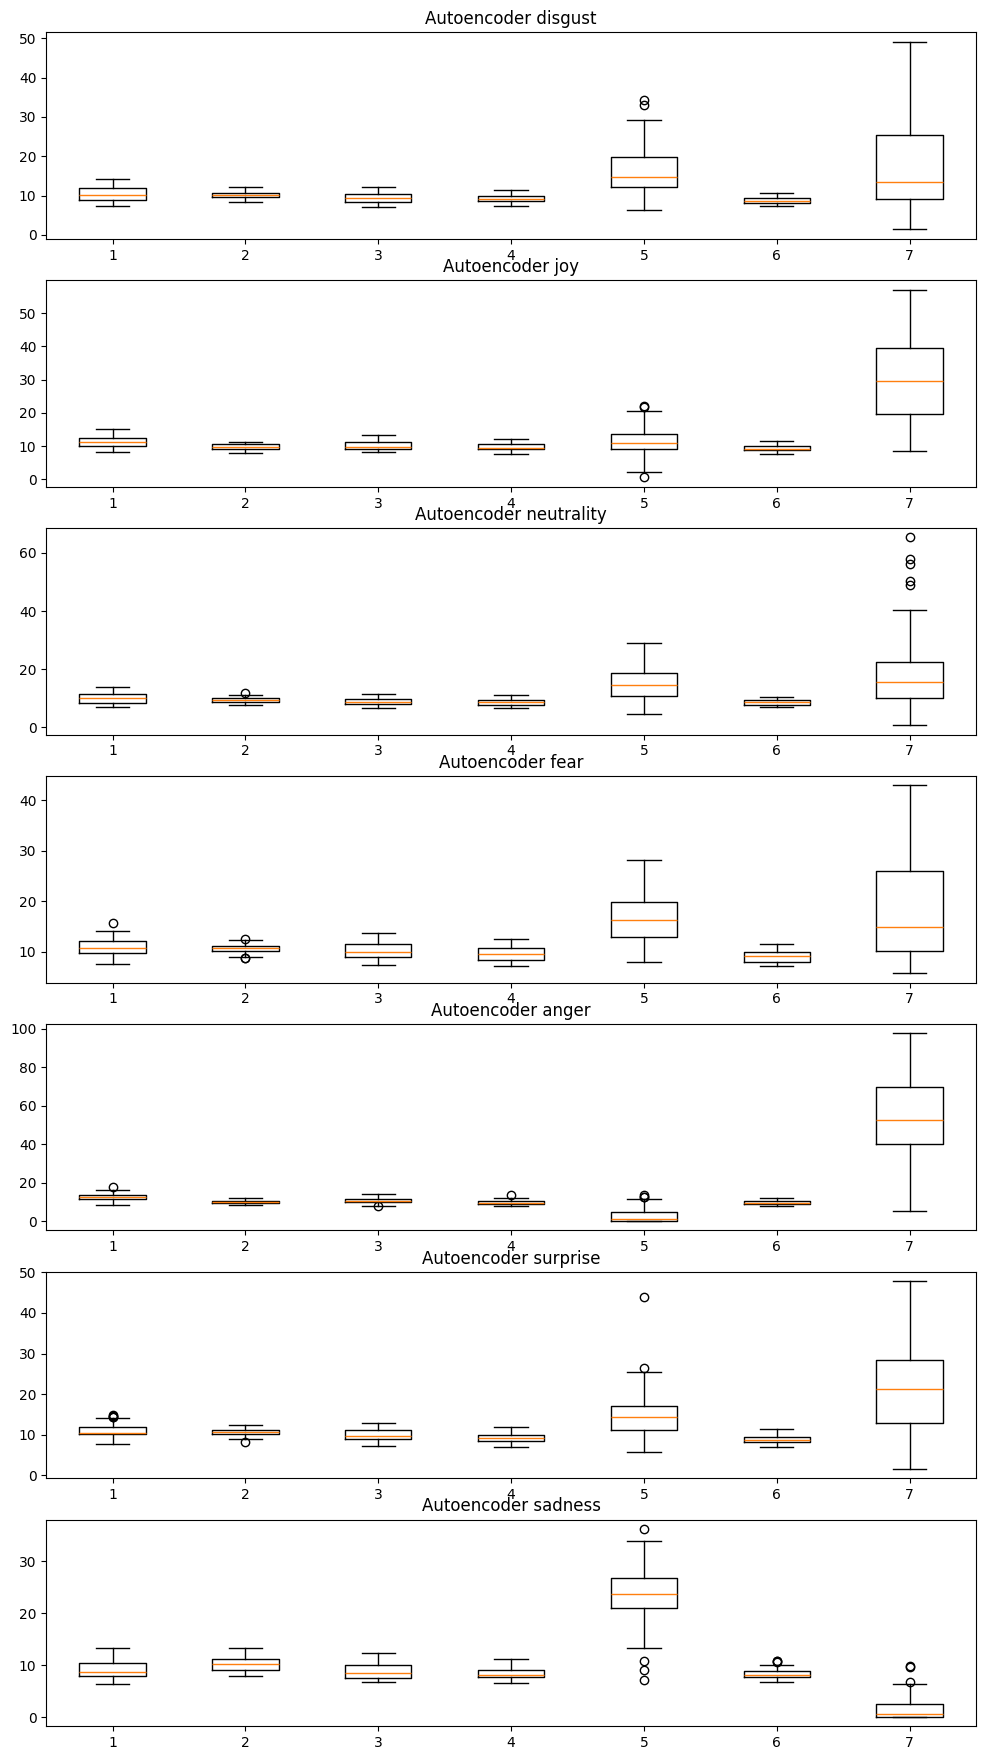

In [ ]:
n_rows = 7
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(12,22))
# for x in range(n_rows):
for i in range(len(labels)):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)
        axes[i].boxplot([emo[i][:,0], emo[i][:,1],emo[i][:,2],emo[i][:,3],emo[i][:,4],emo[i][:,5],emo[i][:,6]])
        axes[i].set_title(f"Autoencoder {labels[i]}")
        # axes[i].set_ylim((0,5))
        # axes[x,i].set_title(f"{labels[i]}")
# fig.suptitle("Train")
# fig.savefig("Boxplot_Contrastive_Total")

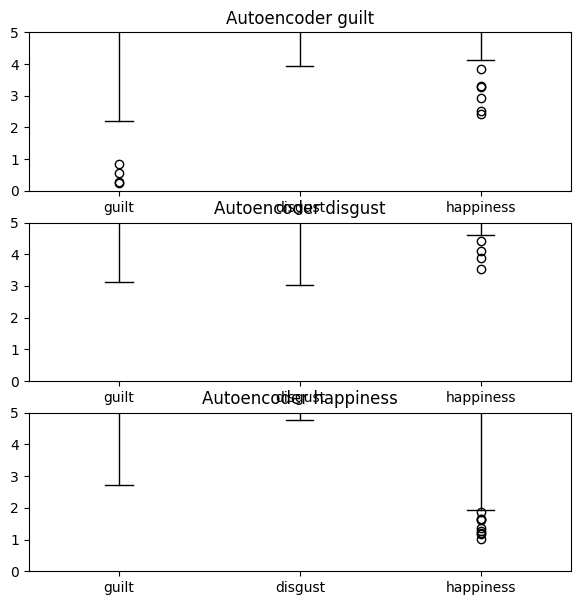

In [28]:
n_rows = 7
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,7))
# for x in range(n_rows):
for i in range(3):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)
        axes[i].boxplot([emo[i][:,0], emo[i][:,1], emo[i][:,2]], tick_labels=labels[:3])
        axes[i].set_title(f"Autoencoder {labels[i]}")
        axes[i].set_ylim((0,5))
        # axes[x,i].set_title(f"{labels[i]}")
# fig.suptitle("Train")
# fig.savefig("Boxplot_Contrastive_EMOVO_3EMO")

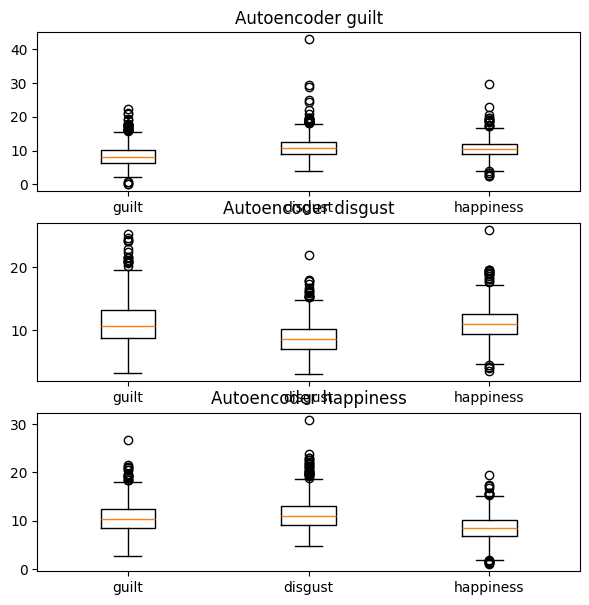

In [26]:
n_rows = 7
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,7))
# for x in range(n_rows):
for i in range(3):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)
        axes[i].boxplot([emo[i][:,0], emo[i][:,1], emo[i][:,2]], tick_labels=labels[:3])
        axes[i].set_title(f"Autoencoder {labels[i]}")
        # axes[x,i].set_title(f"{labels[i]}")
# fig.suptitle("Train")
# fig.savefig("Boxplot_Contrastive_EMOVO_3EMO")

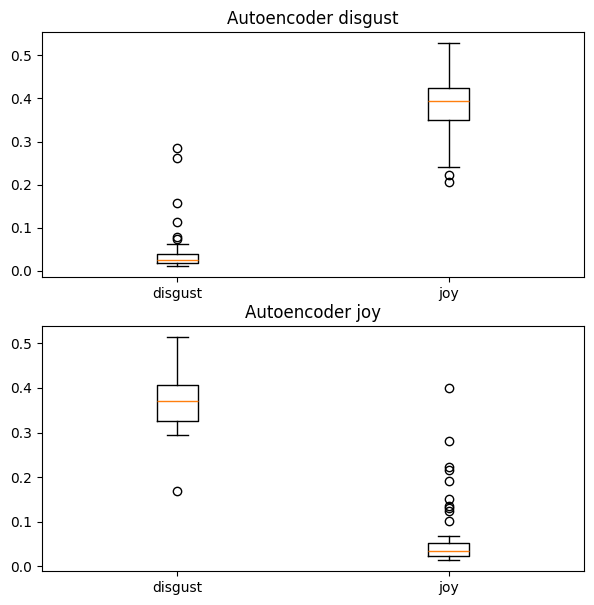

In [106]:
n_rows = 7
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,7))
# for x in range(n_rows):
for i in range(2):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)
        axes[i].boxplot([emo[i][:,0], emo[i][:,1]], tick_labels=labels[:2])
        axes[i].set_title(f"Autoencoder {labels[i]}")
        # axes[x,i].set_title(f"{labels[i]}")
# fig.suptitle("Train")
# fig.savefig("Boxplot_Contrastive_DEMoS")

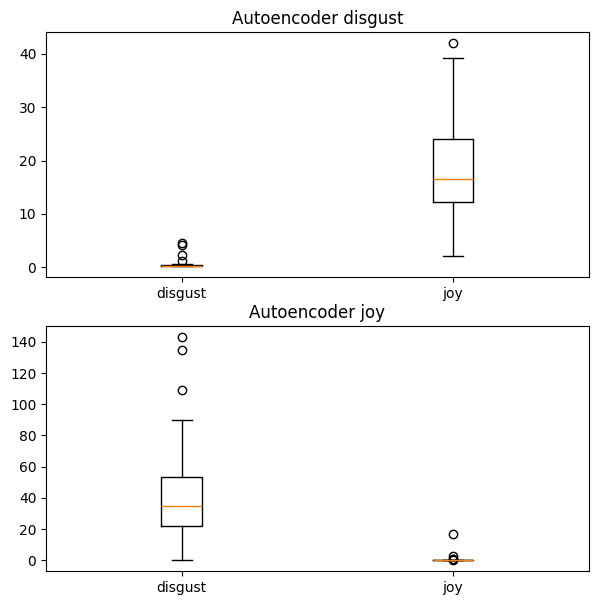

In [277]:
n_rows = 7
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,7))
# for x in range(n_rows):
for i in range(2):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)
        axes[i].boxplot([emo[i][:,0], emo[i][:,1]], tick_labels=labels[:2])
        axes[i].set_title(f"Autoencoder {labels[i]}")
        # axes[x,i].set_title(f"{labels[i]}")
# fig.suptitle("Train")
# fig.savefig("Boxplot_Contrastive_DEMoS")

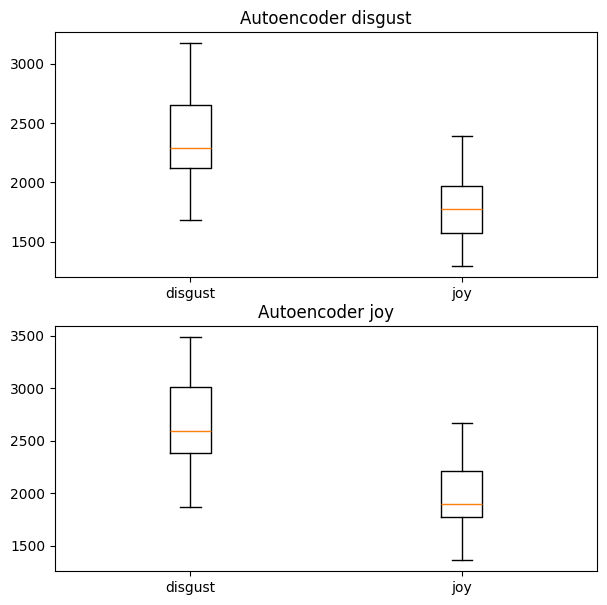

In [270]:
n_rows = 7
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,7))
# for x in range(n_rows):
for i in range(2):
# Crea i boxplot
    # totale = np.concatenate((data_train[:, :i], data_train[:, i:]), axis=1)
        axes[i].boxplot([emo[i][:,0], emo[i][:,1]], tick_labels=labels[:2])
        axes[i].set_title(f"Autoencoder {labels[i]}")
        # axes[x,i].set_title(f"{labels[i]}")
# fig.suptitle("Train")
fig.savefig("Boxplot_Contrastive_DEMoS")

In [178]:
len(emo_test)

3

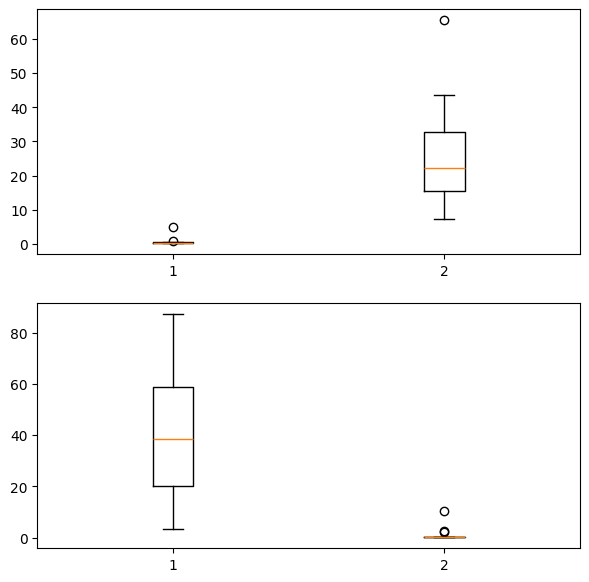

In [160]:
n_rows = 7
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7,7))
# for x in range(n_rows):
for i in range(len(emo_test)):
    axes[i].boxplot([emo_test[i][:,0], emo_test[i][:,1]])
# fig.suptitle("Train")

In [74]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data(clear_df)

y_train = np.argmax(y_train, axis=-1)
y_val = np.argmax(y_val, axis=-1)
y_test = np.argmax(y_test, axis=-1)


In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = y_test

y_pred = []
errors = []


# for n in range(len(df)):
#     X_train = _test[n]

#     cls = []
# for i in range(len())
#     X_train, X_val, X_train, y_train, y_val, y_test = get_data(clear_df)
#     y_test = np.argmax(y_test, axis=-1)
#     _y_test = np.array([1 if x == index else 0 for x in y_test]).reshape(-1,1)

for sample in X_test:
    _er = []
    for encoder in autoencoders:
        _er.append(mean_squared_error(sample,encoder.predict(sample.reshape(-1,88), verbose=0).reshape(88,)))
    errors.append(_er)
    y_pred.append(np.argmin(_er))
    # y_true.append(n)
#pred.append(cls)
# print(cls)

y_pred = np.array(y_pred)

In [49]:
y_true = y_train

In [46]:
y_pred = np.array(y_pred)

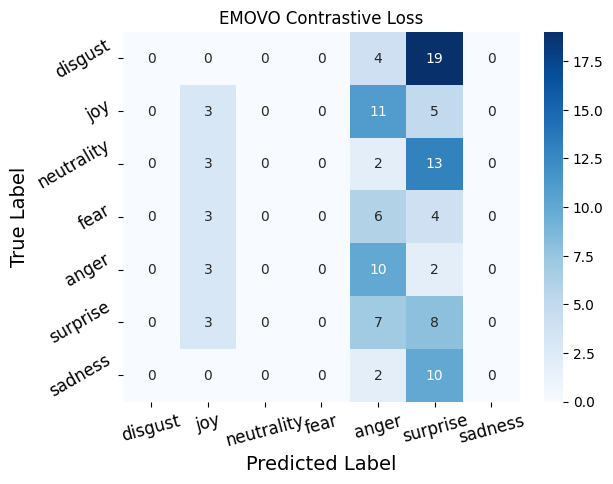

In [70]:
cm = confusion_matrix(y_true,y_pred)

g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
g.set_xlabel("Predicted Label", fontsize=14)
g.set_ylabel("True Label", fontsize = 14)
g.set_title("EMOVO Contrastive Loss")
g.figure.savefig("EMOVO_Contrastive_Loss.png")

# g.set_title(data, fontsize = 18)

In [ ]:
0.20, 0.10
0.17, 0.10

In [78]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average ="weighted")
print(f"Accuracy : {accuracy_score(y_true, y_pred)}")
print(f"F1 score : {f1_score(y_true, y_pred, average ="weighted")}")
print(classification_report(y_true, y_pred, target_names=labels))

Accuracy : 0.2288135593220339
F1 score : 0.18775473978920243
              precision    recall  f1-score   support

     disgust       0.00      0.00      0.00        23
         joy       0.00      0.00      0.00        19
  neutrality       0.19      0.17      0.18        18
        fear       1.00      0.15      0.27        13
       anger       1.00      0.40      0.57        15
    surprise       0.17      0.83      0.28        18
     sadness       1.00      0.08      0.15        12

    accuracy                           0.23       118
   macro avg       0.48      0.23      0.21       118
weighted avg       0.39      0.23      0.19       118



c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [235]:
from sklearn.metrics import average_precision_score, recall_score, precision_score
score = np.array(toto)
true_lab = y_true
ap = average_precision_score(true_lab, score)
ap

0.8122881862432945

In [35]:
from scipy import linalg
def mahal(X,Y):
    if len(X.shape) < 2:
        X = X.reshape(-1,1)
    if len(Y.shape) < 2:
        Y = Y.reshape(-1,1)

    [rx,cx] = X.shape
    [ry,cy] = Y.shape

    m = np.mean(X)
    M = m*(np.ones((ry,1)))
    C = X - m*(np.ones((rx,1)))
    [Q,R] = linalg.qr(C, mode= "economic")
    ri = np.linalg.solve(R.T, (Y - M).T) # ri = R.T/(Y-M).T
    d = (sum(ri*ri).T)*(rx-1)

    return d

In [166]:
print(y_test[0])
Y = test_errors[0][0]
for i in range(train_errors.shape[-1]):
    X = train_errors[:,i]
    print((mahal(X,Y)))

6
[0.01367941]
[5.78288114]
[3.12325333]
[1.55968084]
[0.09869132]
[0.29192032]
[0.38180489]


In [ ]:
    Y = sample[0]
    cls = []
    for i in range(train_errors.shape[-1]):
        X = train_errors[:,i]
        cls.append((mahal(X,Y)))
    _cls.append(np.argmin(cls))

array([[0.06382055, 0.08918861, 0.086753  , 0.07132909, 0.06480014,
        0.05682601, 0.05620693],
       [0.05785371, 0.0842325 , 0.07616965, 0.07443152, 0.05351074,
        0.06271701, 0.0688151 ],
       [0.04074868, 0.09004427, 0.07320073, 0.06494483, 0.08175506,
        0.05408303, 0.04123717],
       [0.05402949, 0.07703185, 0.06755157, 0.0531026 , 0.04646649,
        0.05357753, 0.06086166],
       [0.05975382, 0.09328955, 0.1003588 , 0.0978185 , 0.07769022,
        0.09110305, 0.1085225 ],
       [0.05128636, 0.07699793, 0.07630631, 0.06606958, 0.04507291,
        0.05842243, 0.07920655],
       [0.06407165, 0.09083491, 0.08413033, 0.0798219 , 0.08993577,
        0.06206187, 0.06190293],
       [0.0576935 , 0.090171  , 0.10967789, 0.08544317, 0.06302489,
        0.06335828, 0.06972571],
       [0.05611726, 0.09090119, 0.09045769, 0.08152744, 0.06761346,
        0.06860913, 0.07978535],
       [0.04671149, 0.07799742, 0.08276327, 0.06361178, 0.04515039,
        0.05360638, 0.0

In [129]:
test_errors[0]

array([0.05786201, 0.08824639, 0.08458975, 0.07452463, 0.07657557,
       0.0599703 , 0.05991942], dtype=float32)

Text(0.5, 1.0, 'EMOVO Contrastive Loss')

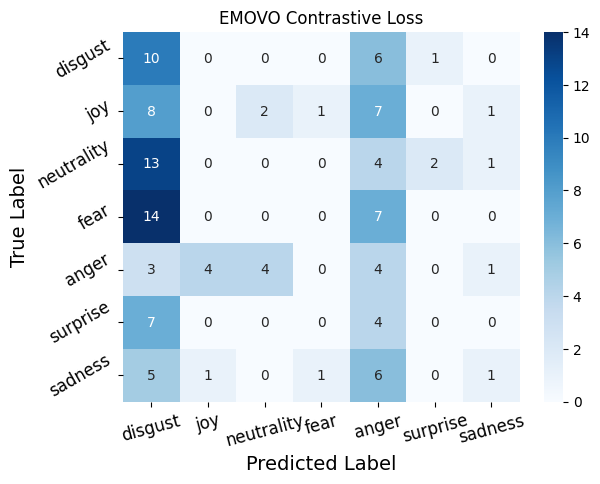

In [126]:
cm = confusion_matrix(y_true,_cls)

g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
g.set_xlabel("Predicted Label", fontsize=14)
g.set_ylabel("True Label", fontsize = 14)
g.set_title("EMOVO Contrastive Loss")
# g.figure.savefig("EMOVO_Contrastive_Loss.png")

# g.set_title(data, fontsize = 18)

# EXTRA

In [11]:
from datetime import datetime  

X_train, X_val, X_test, y_train, y_val, y_test = get_data(clear_df)

y_train = np.argmax(y_train, axis=-1)
_y_train = np.array([1 if x == 0 else 0 for x in y_train]).reshape(-1,1)
y_val = np.argmax(y_val, axis=-1)
_y_val = np.array([1 if x == 0 else 0 for x in y_val]).reshape(-1,1)

y_true = np.hstack([X_train, _y_train])
_y_val = np.hstack([X_val, _y_val])


y_test = np.argmax(y_test, axis=-1)
_y_test = np.array([1 if x == 1 else 0 for x in y_test]).reshape(-1,1)

In [12]:
input_dim = X_train.shape[-1]       

autoencoder = build_autoencoder(input_dim=input_dim)


# autoencoder.summary()
# Compilazione
autoencoder.compile(optimizer='adam', loss=custom_loss)

name = datetime.now().strftime(f"model/autoencoders/contrastive/ae_{emotion}_contrastive_%d_%m_%Y_%H_%M_%S.keras")
print(f"training on {emotion}")
print(f"Model name : {name}")

callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath = name,
    save_best_only=True,
    verbose=3,
    monitor="val_loss"),
keras.callbacks.EarlyStopping(  
    monitor="val_loss",
    min_delta=0.001,
    patience=100,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)
]

autoencoder.fit(X_train, y_true, 
                validation_data = (X_val, _y_val),
                epochs=1000, batch_size=128,
                callbacks = callbacks)


training on sadness
Model name : model/autoencoders/contrastive/ae_sadness_contrastive_12_11_2024_15_17_48.keras
Epoch 1/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step - loss: 0.4038
Epoch 1: val_loss improved from inf to 0.54242, saving model to model/autoencoders/contrastive/ae_sadness_contrastive_12_11_2024_15_17_48.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4686 - val_loss: 0.5424
Epoch 2/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5297
Epoch 2: val_loss improved from 0.54242 to 0.48386, saving model to model/autoencoders/contrastive/ae_sadness_contrastive_12_11_2024_15_17_48.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4598 - val_loss: 0.4839
Epoch 3/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3274
Epoch 3: val_loss improved from 0.48386 to 0.44790, saving model to model/autoencoders/contrastive/ae_sadness_contrastive_12_11_2024_15_17_48.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3615 - val_loss: 0.4479
Epoch 4/1000
1/3 ━━━━━━━━━━━━━━━

In [291]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
correct = []
non_correct = []
for i in range(len(X_test)):
    if _y_test[i] == 1:
        correct.append(mean_squared_error(X_test[i], autoencoder.predict(X_test, verbose=0)[i]))
    else:
        non_correct.append(mean_squared_error(X_test[i], autoencoder.predict(X_test, verbose = 0)[i]))

In [292]:
np.mean(correct), np.mean(non_correct)

(0.07332973, 0.06680409)

In [293]:
X_test[2]

array([0.7231745 , 0.21557094, 0.76988995, 0.72888285, 0.6749056 ,
       0.12488684, 0.06204726, 0.0045168 , 0.15459087, 0.00753841,
       0.31546775, 0.40919608, 0.02845359, 0.23890267, 0.3670773 ,
       0.4330053 , 0.33374798, 0.22734918, 0.39773378, 0.311731  ,
       0.2661014 , 0.37129256, 0.5107753 , 0.25148067, 0.5827248 ,
       0.6496717 , 0.4650464 , 0.2537711 , 0.35398892, 0.95332634,
       0.08053111, 0.69465137, 0.12674408, 0.6766663 , 0.8089537 ,
       0.32204676, 0.51274544, 0.8062683 , 0.41970977, 0.12826012,
       0.30246145, 0.6310856 , 0.6418003 , 0.26309034, 0.35097596,
       0.72138757, 0.49588886, 0.4830092 , 0.47055778, 0.55832076,
       0.5676825 , 0.6758685 , 0.33238426, 0.5898691 , 0.5892035 ,
       0.62206924, 0.5868525 , 0.62680614, 0.3961237 , 0.01664707,
       0.44694278, 0.08353613, 0.5577996 , 0.15245771, 0.278539  ,
       0.80661595, 0.30426744, 0.58604676, 0.54511577, 0.33809322,
       0.47493795, 0.7040352 , 0.47442085, 0.7394053 , 0.23868

In [17]:
X_test[2], _y_test[2]

(array([0.7231745 , 0.21557094, 0.76988995, 0.72888285, 0.6749056 ,
        0.12488684, 0.06204726, 0.0045168 , 0.15459087, 0.00753841,
        0.31546775, 0.40919608, 0.02845359, 0.23890267, 0.3670773 ,
        0.4330053 , 0.33374798, 0.22734918, 0.39773378, 0.311731  ,
        0.2661014 , 0.37129256, 0.5107753 , 0.25148067, 0.5827248 ,
        0.6496717 , 0.4650464 , 0.2537711 , 0.35398892, 0.95332634,
        0.08053111, 0.69465137, 0.12674408, 0.6766663 , 0.8089537 ,
        0.32204676, 0.51274544, 0.8062683 , 0.41970977, 0.12826012,
        0.30246145, 0.6310856 , 0.6418003 , 0.26309034, 0.35097596,
        0.72138757, 0.49588886, 0.4830092 , 0.47055778, 0.55832076,
        0.5676825 , 0.6758685 , 0.33238426, 0.5898691 , 0.5892035 ,
        0.62206924, 0.5868525 , 0.62680614, 0.3961237 , 0.01664707,
        0.44694278, 0.08353613, 0.5577996 , 0.15245771, 0.278539  ,
        0.80661595, 0.30426744, 0.58604676, 0.54511577, 0.33809322,
        0.47493795, 0.7040352 , 0.47442085, 0.73

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
(_y_test[2])* mean_squared_error(X_test[2],autoencoder.predict(X_test[2].reshape(-1,88), verbose=0).reshape(88,))

array([0.04580529])

In [26]:
mean_squared_error(X_test[1],autoencoder.predict(X_test[1].reshape(-1,88), verbose=0).reshape(88,))

0.054198936

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = []

y_pred = []
errors = []
_test = []



    er.append(mean_squared_error(X_test[i],autoencoder.predict(X_test[i].reshape(-1,88)).reshape(88,)))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = []

y_pred = []
errors = []
_test = []

for n in range(len(X_test)):
    test = X_test[n]

    cls = []
    for i in (range(len(X_test))):
        _er = []

            #print(labels[x])
            _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88)).reshape(88,)))
        errors.append(_er)
        y_pred.append(np.argmin(_er))
        y_true.append(n)
    #pred.append(cls)
    print(cls)